In [2]:
import keras
from keras.models import Model
from keras.layers import *
from keras.applications.inception_resnet_v2 import InceptionResNetV2
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

In [3]:
INPUT_SHAPE = (256, 256, 1)
ENCODER_SHAPE = (224, 224, 1)
INCEPTION_SHAPE = (299, 299, 3)

BATCH_SIZE = 64

# DATA

### Loading the Datasets

In [ ]:
!tar -zxvf {'Colorization.tar.gz'}

In [6]:
train = tf.data.Dataset.load('TFRecord/train.tfrecord')
test = tf.data.Dataset.load('TFRecord/test.tfrecord')

### Processing the Data

In [8]:
def process(gray, color):
    img1 = tf.image.resize(gray, (INPUT_SHAPE[0], INPUT_SHAPE[1]))
    img2 = tf.image.resize(color, (INPUT_SHAPE[0], INPUT_SHAPE[1]))
    img1 = (tf.cast(img1, tf.float32)-127.5)/127.5
    img2 = (tf.cast(img2, tf.float32)-127.5)/127.5
    return img1, img2

train = train.map(process).cache().shuffle(30000).batch(BATCH_SIZE)
test = test.map(process).cache().shuffle(6000).batch(BATCH_SIZE)

In [10]:
len(train), len(test)

(420, 86)

### Testing the Dataset

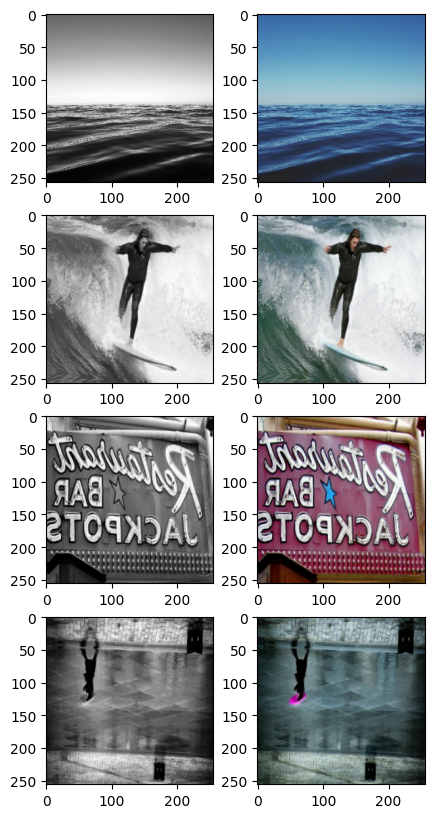

In [11]:
sample = test.as_numpy_iterator().next()
fig, ax = plt.subplots(4,2, figsize=(5, 10))
for i in range(4):
    ax[i][0].imshow(tf.cast(sample[0][i]*127.5+127.5, dtype=tf.uint8), cmap='gray')
    ax[i][1].imshow(tf.cast(sample[1][i]*127.5+127.5, dtype=tf.uint8))

# MODEL

### Building the Model

In [12]:
class Autoencoder(Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = self.build_encoder()

        inception = InceptionResNetV2(True, input_shape=INCEPTION_SHAPE)
        self.extractor = Model(inception.inputs,Dense(1001)(inception.get_layer('avg_pool').output))
        self.extractor.trainable = False
        for layer in self.extractor.layers:
            layer.trainable = False

        self.decoder = self.build_decoder()
        self.model = self.build_model()


    # Builds the Encoder
    def build_encoder(self):
        input = Input(ENCODER_SHAPE)

        x = Conv2D(64, 3, 2, 'same', activation='relu', kernel_initializer=tf.initializers.RandomNormal(mean=0.0, stddev=0.02))(input)
        x = Conv2D(128, 3, 1, 'same', activation='relu', kernel_initializer=tf.initializers.RandomNormal(mean=0.0, stddev=0.02))(x)
        x = Conv2D(128, 3, 2, 'same', activation='relu', kernel_initializer=tf.initializers.RandomNormal(mean=0.0, stddev=0.02))(x)
        x = Conv2D(256, 3, 1, 'same', activation='relu', kernel_initializer=tf.initializers.RandomNormal(mean=0.0, stddev=0.02))(x)
        x = Conv2D(256, 3, 2, 'same', activation='relu', kernel_initializer=tf.initializers.RandomNormal(mean=0.0, stddev=0.02))(x)
        x = Conv2D(512, 3, 1, 'same', activation='relu', kernel_initializer=tf.initializers.RandomNormal(mean=0.0, stddev=0.02))(x)
        x = Conv2D(512, 3, 1, 'same', activation='relu', kernel_initializer=tf.initializers.RandomNormal(mean=0.0, stddev=0.02))(x)
        out = Conv2D(256, 3, 1, 'same', activation='relu', kernel_initializer=tf.initializers.RandomNormal(mean=0.0, stddev=0.02))(x)

        return Model(inputs=input, outputs=out)


    # Builds the Decoder
    def build_decoder(self):
        input = Input((int(ENCODER_SHAPE[0]/8), int(ENCODER_SHAPE[1]/8), 1257))

        x = Conv2D(256, 1, 1, 'same', activation='relu', kernel_initializer=tf.initializers.RandomNormal(mean=0.0, stddev=0.02))(input)
        x = Conv2DTranspose(128, 3, 1, 'same', activation='relu', kernel_initializer=tf.initializers.RandomNormal(mean=0.0, stddev=0.02))(x)
        x = UpSampling2D()(x)
        x = Conv2DTranspose(64, 3, 1, 'same', activation='relu', kernel_initializer=tf.initializers.RandomNormal(mean=0.0, stddev=0.02))(x)
        x = Conv2DTranspose(64, 3, 1, 'same', activation='relu', kernel_initializer=tf.initializers.RandomNormal(mean=0.0, stddev=0.02))(x)
        x = UpSampling2D()(x)
        x = Conv2DTranspose(48, 3, 1, 'same', activation='relu', kernel_initializer=tf.initializers.RandomNormal(mean=0.0, stddev=0.02))(x)
        out = UpSampling2D()(x)

        return Model(inputs=input, outputs=out)


    # Builds and Connects the Model
    def build_model(self):
        inputs = Input(INPUT_SHAPE)

        inp = Resizing(ENCODER_SHAPE[0], ENCODER_SHAPE[1])(inputs)
        x = self.encoder(inp, training=False)

        y = Resizing(INCEPTION_SHAPE[0], INCEPTION_SHAPE[1])(inputs)
        y = Concatenate()([y, y, y])
        y = self.extractor(y)
        y = tf.expand_dims(y, 1)
        y = tf.expand_dims(y, 1)
        y = tf.tile(y, (1, ENCODER_SHAPE[0]//8, ENCODER_SHAPE[0]//8, 1))

        z = Concatenate()([x, y])
        z = self.decoder(z, training=False)

        inp = Conv2D(16, 3, 1, 'same', activation='relu', kernel_initializer=tf.initializers.RandomNormal(mean=0.0, stddev=0.02))(inp)
        c = Concatenate()([inp, z])
        c = Conv2D(32, 3, 1, 'same', activation='relu', kernel_initializer=tf.initializers.RandomNormal(mean=0.0, stddev=0.02))(c)
        out = Conv2D(3, 3, 1, 'same', activation='tanh', kernel_initializer=tf.initializers.RandomNormal(mean=0.0, stddev=0.02))(c)

        return Model(inputs, out)


    def compile(self, opt, loss):
        super().compile()
        self.opt = opt
        self.loss = loss


    def train_step(self, batch):
        with tf.GradientTape() as tape:
            output = self.model(batch[0], training=True)
            resized = Resizing(ENCODER_SHAPE[0], ENCODER_SHAPE[1])(batch[1])

            loss_val = self.loss(resized, output)

            gradients = tape.gradient(loss_val, self.model.trainable_variables)

        self.opt.apply_gradients(zip(gradients, self.model.trainable_variables))

        return {"loss": loss_val}


    def test_step(self, batch):
        output = self(batch[0])
        resized = Resizing(ENCODER_SHAPE[0], ENCODER_SHAPE[1])(batch[1])

        loss_val = self.loss(resized, output)

        return {"loss": loss_val}


    def save(self, path):
        self.model.save(path)


    def call(self, inputs):
        return self.model(inputs, training=False)



In [20]:
model = Autoencoder()
model.model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 resizing_1 (Resizing)       (None, 299, 299, 1)          0         ['input_4[0][0]']             
                                                                                                  
 concatenate (Concatenate)   (None, 299, 299, 3)          0         ['resizing_1[0][0]',          
                                                                     'resizing_1[0][0]',          
                                                                     'resizing_1[0][0]']          
                                                                                            

In [15]:
model.compile(keras.optimizers.Adam(), keras.losses.MeanSquaredError())

### Training the Model

In [ ]:
model.fit(train, epochs=100, validation_data=test)

### Testing the Model

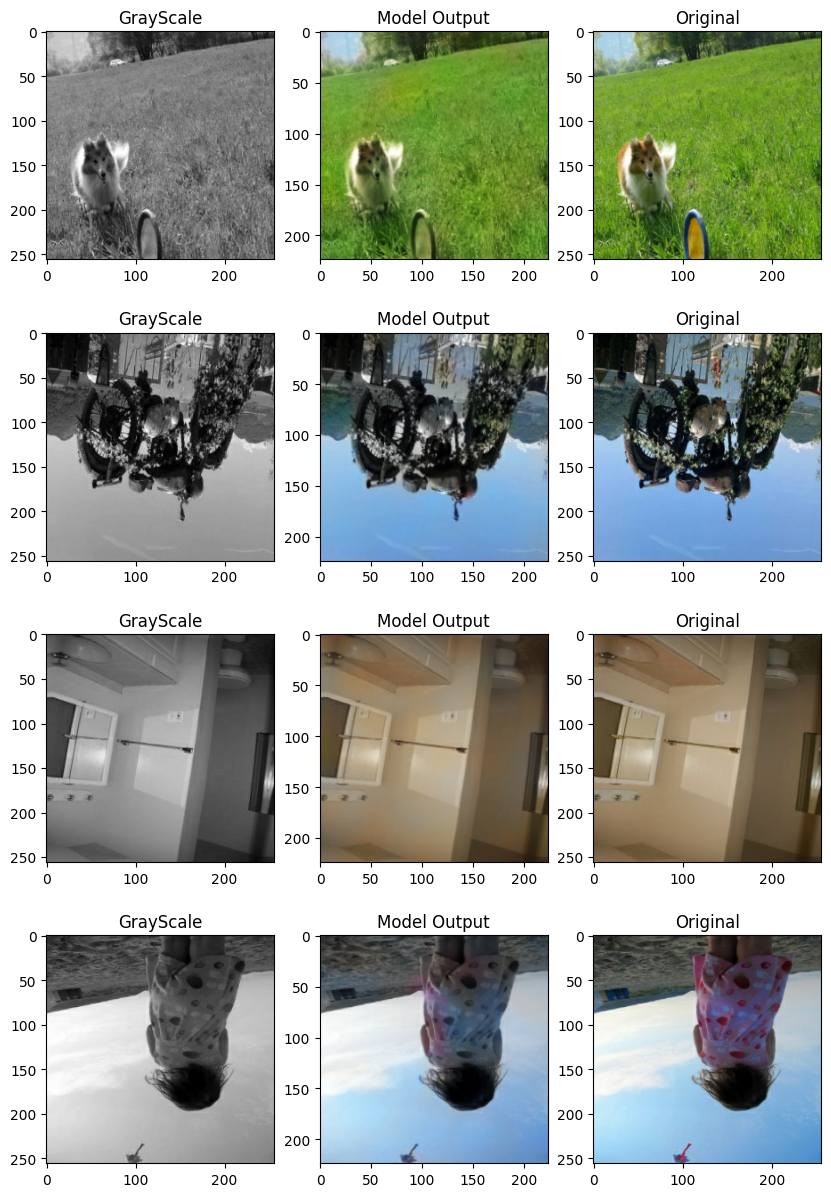

In [17]:
samples = test.as_numpy_iterator().next()

outputs = model(samples[0])

fig, ax = plt.subplots(4,3, figsize=(10, 15))
for i in range(4):
    ax[i][0].imshow(tf.cast(samples[0][i]*127.5+127.5, dtype=tf.uint8), cmap='gray')
    ax[i][0].set_title('GrayScale')
    ax[i][1].imshow(tf.cast(outputs[i]*127.5+127.5, dtype=tf.uint8))
    ax[i][1].set_title('Model Output')
    ax[i][2].imshow(tf.cast(samples[1][i]*127.5+127.5, dtype=tf.uint8))
    ax[i][2].set_title('Original')

### Saving the Model

In [ ]:
model.save('Autoencoder.h5')